In this chapter we will try to implement GPT-2 and simulate it's training

In [1]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "emb_dim": 768,          # Embedding dimension
    "n_heads": 12,           # Number of attention heads
    "n_layers": 12,          # Number of layers
    "drop_rate": 0.1,        # Dropout rate
    "qkv_bias": False        # Query-Key-Value bias
}

In [2]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(               #1
            *[DummyTransformerBlock(cfg)               #1
              for _ in range(cfg["n_layers"])]         #1
        )                                              #1
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])     #2
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

class DummyTransformerBlock(nn.Module):    #3
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):     #4
        return x

class DummyLayerNorm(nn.Module):           #5
    def __init__(self, normalized_shape, eps=1e-5):    #6
        super().__init__()

    def forward(self, x):
        return x

Let's see how text is encoded into tokens in a batch of text.

In [3]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [4]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


### Layer Normalization

In [5]:
torch.manual_seed(123)
batch_example = torch.randn(2, 5)     #1
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [6]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [7]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

GELU ACTIVATION FUNCTION

In [8]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

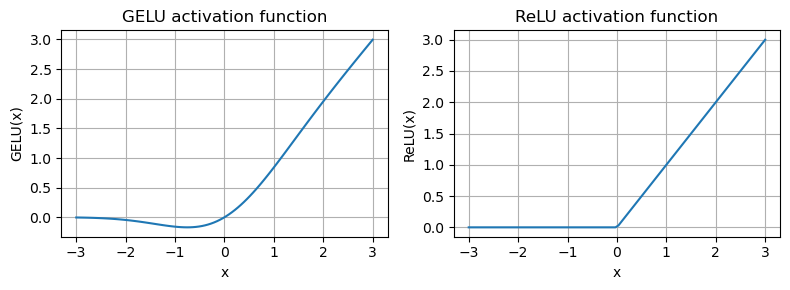

In [9]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)     #1
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

To sum up , the transformer block we are adding to the model works as follows:

Embedding layer:
1. We have a token embedding matrix that maps tokens to their embeddings.
2. We have a positional embedding matrix that maps positions to their embeddings.
3. We add the token embeddings and the positional embeddings to get the input embeddings.

Layer Normalization:
1. We normalize the input embeddings to have a mean of 0 and a standard deviation of 1.
2. We scale the normalized embeddings by a learned scale parameter.
3. We shift the scaled embeddings by a learned shift parameter.

Masked Multi-Head Attention:
1. We have a query, key, and value matrix.
2. We have a mask matrix that masks the future tokens.
3. We pass the query, key, and value matrices to the attention layer.
4. We get the attention scores.
5. We apply the softmax function to the attention scores to get the attention weights.
6. We multiply the attention weights by the value matrix to get the output.

We do this parallel for each head in the transformer block.

Dropout Layer:

We drop some of the attention weights to prevent overfitting and rescale the remaining weights.

Shortcut layer:

We add the input embeddings to the output of the transformer block.
to recover the information that might have been lost in the gradient flow.

Layer Normalization 2  :

We normalize the output of the shortcut layer to have a mean of 0 and a standard deviation of 1.


Feed Forward Layer:

We have a linear layer that takes the output of the attention layer and passes it through a GELU activation function and a linear layer.
We can think of it as model actually thinking about the meaning of tokens after understanding the context of the tokens.


Dropout Layer 2:

We drop some of the output of the feed forward layer to prevent overfitting and rescale the remaining weights.


Shortcut layer 2:

We add the output of the feed forward layer to the output of the first shortcut layer.
to recover the information that might have been lost in the gradient flow.

End: 

We have a matrix that has the same dimension as the input
















### Final Transformer Block

In [11]:
from final_gpt import MultiHeadAttention

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
 #1
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut      #2

        shortcut = x         #3
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut      #4
        return x

In [12]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
 #1
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

Our logits are of shape (batch_size, seq_len, vocab_size).

The reason for this is that for each batch we are making seq_len predictions and each prediction is a probability distribution over the vocabulary.

Even though they do not sum to 1 since we will use the softmax function to get the probability distribution and train model in a stable manner we are essentially teaching model to predict the logits which are 1 step before the actual predictions



### Actually getting the predictions

Now we have our logits.The next step is to get the predictions.

Lets say that we had:

seq_len = 3
batch_size = 2
vocab_size = 5

This means that we will make 3 predictions for each batch and those predictions will have 5 outputs each.For each 3 prediction we will only interested in the last prediction because it is the only prediction we dont actually know.Therefore:


1.We will get the logits for the last prediction
2.We will apply the softmax function to the logits to get the probability distribution
3.We will get the one with the highest probability
4.We will identify it's position in the vocabulary
5.We will use it as the next input to the model
6.Decode the token back to text









In [13]:
def generate_text_simple(model, idx,                 #1
                         max_new_tokens, context_size): 
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]    #2
        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :]                    #3
        probas = torch.softmax(logits, dim=-1)           #4
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)    #5
        idx = torch.cat((idx, idx_next), dim=1)     #6

    return idx

Now lets try that in practice

In [14]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)    #1
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [15]:
model.eval()                  #1
out = generate_text_simple(
    model=model,
    idx=encoded_tensor, 
    max_new_tokens=6, 
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 12170, 44251, 25952, 49216, 30322,  6868]])
Output length: 10


In [16]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am drone Omni SSLmyra muc native


After training the model will be able to generate text which will make more sense